In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [7]:
def data_generator(image_paths, labels, batch_size=4):

    while True:
        indices = np.random.permutation(len(image_paths))
        image_paths = np.array(image_paths)[indices]
        labels = labels[indices]
        
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = [tf.keras.preprocessing.image.load_img(path, target_size=(512, 512)) for path in batch_paths]
            batch_images = [tf.keras.preprocessing.image.img_to_array(img) for img in batch_images]
            batch_images = np.array(batch_images) / 255.0 
            batch_labels = labels[i:i+batch_size]
            
            yield batch_images, batch_labels


In [8]:
data = pd.read_csv('dataset_markup.csv')

image_paths = data['Image_path'].tolist()
image_dir = "images"
image_paths = [os.path.join(image_dir, filename) for filename in image_paths]
labels = data[['Emotional_coloring', 'Plot_complexity', 'Interest', 'Sound_quality']].values

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
batch_size=4


print(len(train_image_paths), len(test_image_paths))


64 28


In [9]:
train_generator = data_generator(train_image_paths, train_labels)
test_generator = data_generator(test_image_paths, test_labels)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4)  # Выходной слой с 4 нейронами для каждого критерия оценки
])

model.compile(optimizer='adam',
              loss='mse',  # Среднеквадратичная ошибка
              metrics=['mae'])  # Средняя абсолютная ошибка

In [10]:
history = model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch=len(train_image_paths) // batch_size,
                    validation_data=test_generator,
                    validation_steps=len(test_image_paths) // batch_size,
                    verbose=1)

Epoch 1/30
16/16 [==============================] - 5s 122ms/step - loss: 50.5440 - mae: 3.5286 - val_loss: 8.2024 - val_mae: 2.1139
Epoch 2/30
16/16 [==============================] - 2s 110ms/step - loss: 6.7594 - mae: 1.9707 - val_loss: 6.9315 - val_mae: 1.9192
Epoch 3/30
16/16 [==============================] - 2s 110ms/step - loss: 5.9661 - mae: 1.8712 - val_loss: 6.4657 - val_mae: 1.7884
Epoch 4/30
16/16 [==============================] - 2s 110ms/step - loss: 5.5469 - mae: 1.7645 - val_loss: 6.6071 - val_mae: 2.0750
Epoch 5/30
16/16 [==============================] - 2s 110ms/step - loss: 5.0975 - mae: 1.6652 - val_loss: 5.8125 - val_mae: 1.8393
Epoch 6/30
16/16 [==============================] - 2s 110ms/step - loss: 4.0066 - mae: 1.4733 - val_loss: 5.0790 - val_mae: 1.8830
Epoch 7/30
16/16 [==============================] - 2s 110ms/step - loss: 2.6533 - mae: 1.2148 - val_loss: 6.1821 - val_mae: 1.7582
Epoch 8/30
16/16 [==============================] - 2s 110ms/step - loss: 2

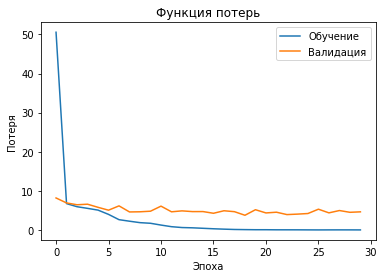

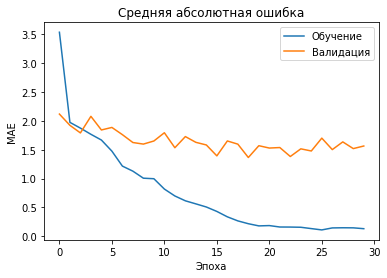

In [11]:
import matplotlib.pyplot as plt

# График функции потерь
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.savefig('loss_plot.png', dpi=300)  # Сохранение графика как изображения
plt.show()

# График средней абсолютной ошибки
plt.plot(history.history['mae'], label='Обучение')
plt.plot(history.history['val_mae'], label='Валидация')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.savefig('mae_plot.png', dpi=300)  # Сохранение графика как изображения
plt.show()

In [12]:
model.save('paintings_model.h5')